In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = "retina"

# Stellar rotation with Gaussian Processes

In [3]:
from periodicity.data import spotted_lc
from periodicity.gp import FastGPModeler, make_gaussian_prior
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
plt.rc('lines', linewidth=1.0, linestyle='-', color='black')
plt.rc('font', family='sans-serif', weight='normal', size=12.0)
plt.rc('text', color='black', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{cmbright}')
plt.rc('axes', edgecolor='black', facecolor='white', linewidth=1.0, grid=False,
       titlesize='x-large', labelsize='x-large', labelweight='normal', labelcolor='black')
plt.rc('axes.formatter', limits=(-4, 4))
plt.rc(('xtick', 'ytick'), labelsize='x-large', direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc(('xtick.major', 'ytick.major'), size=7, pad=6, width=1.0)
plt.rc(('xtick.minor', 'ytick.minor'), size=4, pad=6, width=1.0, visible=True)
plt.rc('legend', numpoints=1, fontsize='x-large', shadow=False, frameon=False)

In [5]:
np.random.seed(42)

## Gaussian Mixture as a Prior Probability Distribution

In [6]:
time, flux, flux_err = spotted_lc()
flux -= flux.mean()

model = FastGPModeler(time, flux)
model.prior = make_gaussian_prior(time, flux)

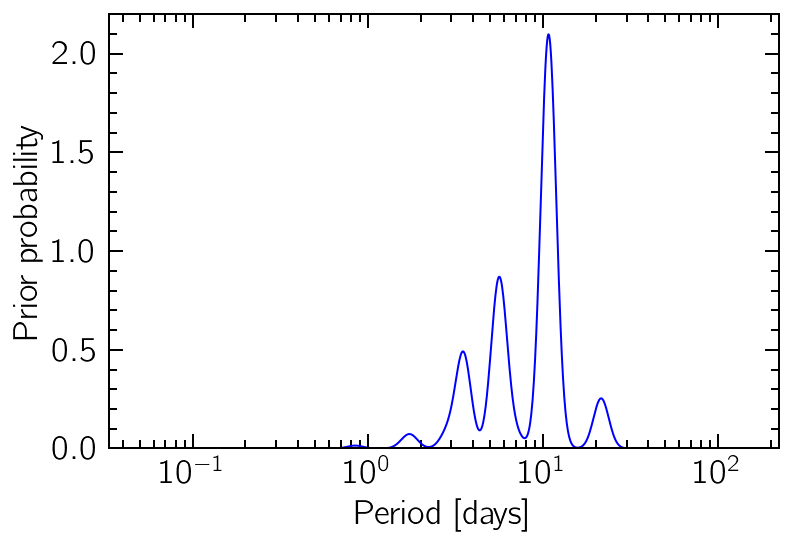

In [7]:
log_periods = np.linspace(-3, 5, 1000)
prior_probs = model.prior(log_periods)
plt.plot(np.exp(log_periods), prior_probs, 'b')
plt.xlabel("Period [days]")
plt.ylabel("Prior probability")
plt.ylim(0)
plt.xscale('log')

## Sampling the Posterior Probability Density

In [8]:
model.minimize()
samples = model.mcmc(n_walkers=16, n_steps=1000, burn=100)

100%|██████████| 1000/1000 [00:19<00:00, 50.87it/s]


In [9]:
print("Median period:", np.exp(np.median(samples[:, 4])))

Median period: 10.62548829733207


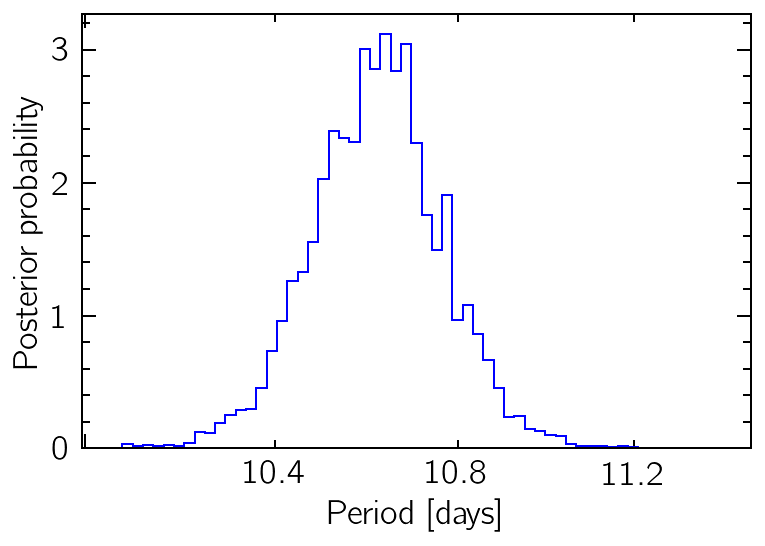

In [10]:
bins = np.logspace(np.min(samples[:, 4]), np.max(samples[:, 4]), 60, base=np.e)
plt.hist(np.exp(samples[:, 4]), bins=bins, histtype='step', color='b', density=True)
plt.xlabel("Period [days]")
plt.ylabel("Posterior probability")
plt.xscale('log')
plt.gca().get_xaxis().set_major_formatter(mpl.ticker.NullFormatter())
plt.gca().get_xaxis().set_minor_formatter(mpl.ticker.ScalarFormatter())
plt.gca().xaxis.set_minor_locator(plt.MaxNLocator(4))

## Plotting the Median Model

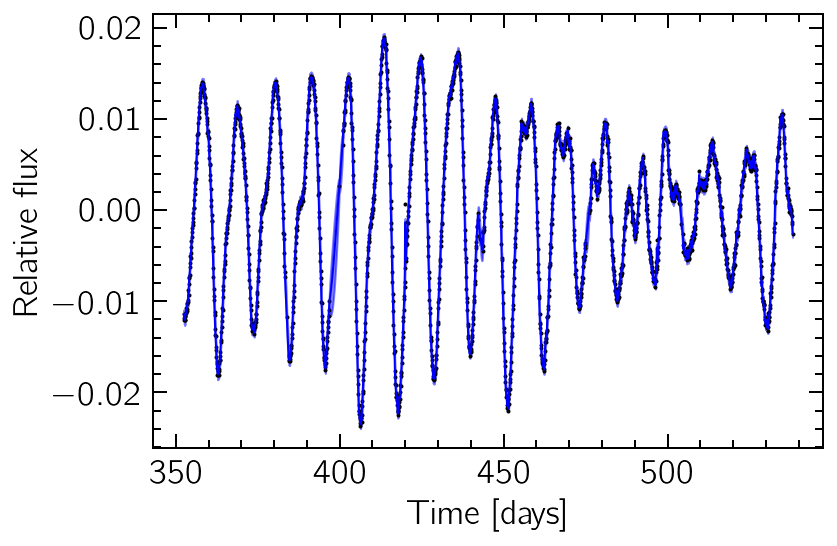

In [11]:
soln = np.median(samples, axis=0)
plt.plot(model.t, model.x, 'k.', ms=2)

model.gp.set_parameter_vector(soln)
model.gp.compute(model.t)

tf = np.linspace(model.t.min(), model.t.max(), 5000)
mu, var = model.gp.predict(model.x, tf, return_var=True)
sd = np.sqrt(var)

plt.plot(tf, mu, 'b')
plt.fill_between(tf, mu-2*sd, mu+2*sd, color='b', alpha=0.5)
_ = plt.xlabel("Time [days]")
_ = plt.ylabel("Relative flux")